In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import f_classif, chi2
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans

In [85]:
df=pd.read_csv("sepsis_data.csv")
# Ensure intime and outtime are datetime objects
# Convert to datetime object, specifying the format
# Convert 'intime' and 'outtime' to datetime without specifying strict format
# Ensure columns are converted to numeric as needed
numeric_columns = [
    'age', 'sysbp_mean', 'heartrate_mean', 'resprate_mean', 
    'wbc_mean', 'hosp_los'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create the high-risk feature combining multiple risk factors
df['high_risk_combined'] = np.where(
    (df['age'] > 65) &  # Advanced age
    (df['diabetes'] == 1) &  # Presence of diabetes
    (df['sysbp_mean'] < 90) &  # Low blood pressure
    (df['heartrate_mean'] > 100) &  # High heart rate
    (df['resprate_mean'] > 20) &  # Rapid breathing
    (df['wbc_mean'] < 4) & (df['wbc_mean'] > 11),  # Prolonged hospital stay
    1,  # Assign 1 if any of the above conditions are met
    0   # Assign 0 otherwise
)

# Verify the result
print(df[['age', 'diabetes', 'sysbp_mean', 'heartrate_mean', 
          'resprate_mean', 'wbc_mean', 'hosp_los', 'high_risk_combined']].head())
# Remove the features that should be excluded
df['shock_index'] = df['heartrate_mean'] / (df['sysbp_mean'] + 1e-5)

# Pulse Pressure: Systolic BP - Diastolic BP
df['pulse_pressure'] = df['sysbp_mean'] - df['diasbp_mean']

# Elixhauser Score: Decompose into individual comorbidities (if available)
# Assuming 'elixhauser_comorbidities' contains individual columns for each comorbidity
# df['diabetes'], df['hypertension'], etc. can be used directly.

# Interaction Features
df['age_creatinine_interaction'] = df['age'] * df['creatinine_max']

# Change Over Time (Delta Features)
# Assuming we have 'heartrate_T1' and 'heartrate_T2'
df['delta_heartrate'] = df['heartrate_max'] - df['heartrate_min']

# Statistical Summaries
# Assuming multiple columns for glucose levels: ['glucose_T1', 'glucose_T2', 'glucose_T3']
glucose_columns = ['glucose_min', 'glucose_max', 'glucose_mean']
df['glucose_mean_summary'] = df[glucose_columns].mean(axis=1)
df['glucose_std_summary'] = df[glucose_columns].std(axis=1)

# Missing Indicator Feature
df['is_creatinine_missing'] = df['creatinine_max'].isna().astype(int)
df = pd.get_dummies(df, columns=['specimen_poe'], prefix='specimen', drop_first=False)

# Abnormal Value Counters
# Assuming normal temperature range is 36.5 to 37.5
features_to_exclude = [
    'thirtyday_expire_flag','icustay_id', 'hadm_id', 'intime', 'outtime', 'subject_id', 'hadm_id.1', 'icustay_id.1', 
    'hospital_expire_flag', 'suspected_infection_time_poe', 'suspected_infection_time_poe_days', 'positiveculture_poe', 'antibiotic_time_poe', 'blood_culture_time', 'blood_culture_positive',
'icu_los', 'hosp_los',
   'icustay_id.1' ,'sepsis_angus', 'sepsis_martin', 'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit', 'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple']
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_columns = [col for col in numeric_columns if col not in features_to_exclude]
binary_columns = [col for col in numeric_columns if df[col].nunique() == 2 and col not in features_to_exclude]

len(binary_columns)
numeric_columns = [col for col in numeric_columns if col not in binary_columns]
numeric_columns

len(numeric_columns)

       age  diabetes  sysbp_mean  heartrate_mean  resprate_mean  wbc_mean  \
0  80.5274         0   97.800000      113.208333      24.419355     14.20   
1  91.4000         0   75.444444       50.000000      26.500000     10.80   
2  80.9409         0  104.085714       99.666667      19.571429     16.10   
3  84.8807         0   88.041667       94.440000      24.520000     10.35   
4  73.8195         0   92.350000       82.937500      32.117647      9.15   

    hosp_los  high_risk_combined  
0   1.931250                   0  
1   0.179861                   0  
2  11.914583                   0  
3   3.435417                   0  
4   0.467361                   0  


71

We exclude any features that would not be available at the time of admission, ensuring that our model avoids data leakage and accurately assesses a patient's risk of mortality based solely on pre-existing factors, such as comorbidities.

In [87]:
numeric_columns

['age',
 'elixhauser_hospital',
 'sofa',
 'lods',
 'sirs',
 'qsofa',
 'aniongap_min',
 'aniongap_max',
 'bicarbonate_min',
 'bicarbonate_max',
 'creatinine_min',
 'creatinine_max',
 'chloride_min',
 'chloride_max',
 'glucose_min',
 'glucose_max',
 'hematocrit_min',
 'hematocrit_max',
 'hemoglobin_min',
 'hemoglobin_max',
 'lactate_min',
 'lactate_max',
 'lactate_mean',
 'platelet_min',
 'platelet_max',
 'potassium_min',
 'potassium_max',
 'inr_min',
 'inr_max',
 'sodium_min',
 'sodium_max',
 'bun_min',
 'bun_max',
 'bun_mean',
 'wbc_min',
 'wbc_max',
 'wbc_mean',
 'heartrate_min',
 'heartrate_max',
 'heartrate_mean',
 'sysbp_min',
 'sysbp_max',
 'sysbp_mean',
 'diasbp_min',
 'diasbp_max',
 'diasbp_mean',
 'meanbp_min',
 'meanbp_max',
 'meanbp_mean',
 'resprate_min',
 'resprate_max',
 'resprate_mean',
 'tempc_min',
 'tempc_max',
 'tempc_mean',
 'spo2_min',
 'spo2_max',
 'spo2_mean',
 'glucose_min1',
 'glucose_max1',
 'glucose_mean',
 'urineoutput',
 'colloid_bolus',
 'crystalloid_bolus'

In [88]:
binary_columns

['is_male',
 'race_white',
 'race_black',
 'race_hispanic',
 'race_other',
 'metastatic_cancer',
 'diabetes',
 'vent',
 'qsofa_sysbp_score',
 'qsofa_gcs_score',
 'qsofa_resprate_score',
 'rrt',
 'is_creatinine_missing']

In [89]:
all_columns = df.columns.tolist()

In [90]:
print(all_columns)

['icustay_id', 'hadm_id', 'intime', 'outtime', 'dbsource', 'suspected_infection_time_poe', 'suspected_infection_time_poe_days', 'positiveculture_poe', 'antibiotic_time_poe', 'blood_culture_time', 'blood_culture_positive', 'age', 'gender', 'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic', 'race_other', 'metastatic_cancer', 'diabetes', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag', 'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin', 'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit', 'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score', 'qsofa_resprate_score', 'aniongap_min', 'aniongap_max', 'bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min', 'glucose_max', 'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'lactate_min', 'lactate_max', 'lacta

In [91]:
# Remove columns that contain "min" or "max"
#numeric_columns = [col for col in numeric_columns if not ('min' in col.lower() or 'max' in col.lower())]
numeric_columns

['age',
 'elixhauser_hospital',
 'sofa',
 'lods',
 'sirs',
 'qsofa',
 'aniongap_min',
 'aniongap_max',
 'bicarbonate_min',
 'bicarbonate_max',
 'creatinine_min',
 'creatinine_max',
 'chloride_min',
 'chloride_max',
 'glucose_min',
 'glucose_max',
 'hematocrit_min',
 'hematocrit_max',
 'hemoglobin_min',
 'hemoglobin_max',
 'lactate_min',
 'lactate_max',
 'lactate_mean',
 'platelet_min',
 'platelet_max',
 'potassium_min',
 'potassium_max',
 'inr_min',
 'inr_max',
 'sodium_min',
 'sodium_max',
 'bun_min',
 'bun_max',
 'bun_mean',
 'wbc_min',
 'wbc_max',
 'wbc_mean',
 'heartrate_min',
 'heartrate_max',
 'heartrate_mean',
 'sysbp_min',
 'sysbp_max',
 'sysbp_mean',
 'diasbp_min',
 'diasbp_max',
 'diasbp_mean',
 'meanbp_min',
 'meanbp_max',
 'meanbp_mean',
 'resprate_min',
 'resprate_max',
 'resprate_mean',
 'tempc_min',
 'tempc_max',
 'tempc_mean',
 'spo2_min',
 'spo2_max',
 'spo2_mean',
 'glucose_min1',
 'glucose_max1',
 'glucose_mean',
 'urineoutput',
 'colloid_bolus',
 'crystalloid_bolus'

In [92]:
# Show which numeric columns have NaN values and how many NaN values each column has
nan_summary = df[numeric_columns].isna().sum().loc[df.isna().sum() > 0].sort_values(ascending=False)

# Display the result
print(nan_summary)


colloid_bolus                 4050
crystalloid_bolus             1194
inr_max                        270
inr_min                        270
tempc_mean                     103
tempc_max                      103
tempc_min                      103
glucose_mean                    30
glucose_max1                    30
glucose_min1                    30
aniongap_min                    14
aniongap_max                    14
sysbp_min                        8
diasbp_mean                      8
diasbp_max                       8
shock_index                      8
pulse_pressure                   8
diasbp_min                       8
sysbp_mean                       8
sysbp_max                        8
platelet_max                     6
platelet_min                     6
wbc_max                          5
wbc_min                          5
hemoglobin_max                   3
bicarbonate_min                  3
bicarbonate_max                  3
hematocrit_min                   3
hemoglobin_min      

In [93]:
df.shape

(4559, 148)

In [94]:
# Step 1: Filter out columns with more than 10 missing values
numeric_features_filtered = [col for col in numeric_columns if df[col].isna().sum() <= 10]

# Step 2: Impute missing values (for columns with 10 or fewer missing values) using the median
df[numeric_features_filtered] = df[numeric_features_filtered].fillna(df[numeric_features_filtered].median())

# Verify the imputation was done correctly
nan_summary1= df[numeric_features_filtered].isna().sum()

print(nan_summary1)


age                           0
elixhauser_hospital           0
sofa                          0
lods                          0
sirs                          0
qsofa                         0
bicarbonate_min               0
bicarbonate_max               0
creatinine_min                0
creatinine_max                0
chloride_min                  0
chloride_max                  0
glucose_min                   0
glucose_max                   0
hematocrit_min                0
hematocrit_max                0
hemoglobin_min                0
hemoglobin_max                0
lactate_min                   0
lactate_max                   0
lactate_mean                  0
platelet_min                  0
platelet_max                  0
potassium_min                 0
potassium_max                 0
sodium_min                    0
sodium_max                    0
bun_min                       0
bun_max                       0
bun_mean                      0
wbc_min                       0
wbc_max 

In [95]:
# Step 2: Define features and target
X_numeric = df[numeric_features_filtered]
y = df['sepsis_explicit']  # Multiclass target variable

# Step 3: Apply ANOVA F-test
f_values, p_values = f_classif(X_numeric, y)

# Step 4: Create a DataFrame of feature names with their p-values
anova_results = pd.DataFrame({
    'Feature': numeric_features_filtered,
    'F-value': f_values,
    'P-value': p_values
})

# Step 5: Sort features by p-value (ascending) to see most significant features
anova_results = anova_results.sort_values(by='P-value')
print(anova_results)


                       Feature     F-value        P-value
2                         sofa  693.319580  2.336355e-142
3                         lods  400.896439   1.522502e-85
38                  sysbp_mean  386.079491   1.418298e-82
53                 shock_index  331.909221   1.219160e-71
36                   sysbp_min  317.355608   1.109708e-68
6              bicarbonate_min  299.146943   5.762312e-65
44                 meanbp_mean  287.018138   1.752131e-62
47               resprate_mean  228.131471   2.474698e-50
42                  meanbp_min  206.966096   6.311154e-46
28                     bun_max  199.235853   2.599695e-44
29                    bun_mean  198.781956   3.234673e-44
27                     bun_min  186.162306   1.421098e-41
7              bicarbonate_max  185.999995   1.536974e-41
54              pulse_pressure  172.093464   1.283288e-38
1          elixhauser_hospital  149.177845   8.801591e-34
39                  diasbp_min  147.071492   2.457543e-33
46            

/Users/racheldaniel/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [52] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/racheldaniel/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [96]:
numeric_features_filtered

['age',
 'elixhauser_hospital',
 'sofa',
 'lods',
 'sirs',
 'qsofa',
 'bicarbonate_min',
 'bicarbonate_max',
 'creatinine_min',
 'creatinine_max',
 'chloride_min',
 'chloride_max',
 'glucose_min',
 'glucose_max',
 'hematocrit_min',
 'hematocrit_max',
 'hemoglobin_min',
 'hemoglobin_max',
 'lactate_min',
 'lactate_max',
 'lactate_mean',
 'platelet_min',
 'platelet_max',
 'potassium_min',
 'potassium_max',
 'sodium_min',
 'sodium_max',
 'bun_min',
 'bun_max',
 'bun_mean',
 'wbc_min',
 'wbc_max',
 'wbc_mean',
 'heartrate_min',
 'heartrate_max',
 'heartrate_mean',
 'sysbp_min',
 'sysbp_max',
 'sysbp_mean',
 'diasbp_min',
 'diasbp_max',
 'diasbp_mean',
 'meanbp_min',
 'meanbp_max',
 'meanbp_mean',
 'resprate_min',
 'resprate_max',
 'resprate_mean',
 'spo2_min',
 'spo2_max',
 'spo2_mean',
 'urineoutput',
 'high_risk_combined',
 'shock_index',
 'pulse_pressure',
 'age_creatinine_interaction',
 'delta_heartrate',
 'glucose_mean_summary',
 'glucose_std_summary']

In [97]:
# Filter results to show only significant p-values (e.g., p-value < 0.05)
significant_numeric_results = anova_results[anova_results['P-value'] < 0.05]

significant_numeric_results

,Feature,F-value,P-value
2,sofa,693.319580,2.336355e-142
3,lods,400.896439,1.522502e-85
38,sysbp_mean,386.079491,1.418298e-82
53,shock_index,331.909221,1.219160e-71
36,sysbp_min,317.355608,1.109708e-68
6,bicarbonate_min,299.146943,5.762312e-65
44,meanbp_mean,287.018138,1.752131e-62
47,resprate_mean,228.131471,2.474698e-50
42,meanbp_min,206.966096,6.311154e-46
28,bun_max,199.235853,2.599695e-44


In [98]:
# Step 1: Filter out columns with more than 10 missing values
binary_features_filtered = [col for col in binary_columns if df[col].isna().sum() <= 10]
binary_features_filtered

['is_male',
 'race_white',
 'race_black',
 'race_hispanic',
 'race_other',
 'metastatic_cancer',
 'diabetes',
 'vent',
 'qsofa_sysbp_score',
 'qsofa_gcs_score',
 'qsofa_resprate_score',
 'rrt',
 'is_creatinine_missing']

In [99]:
nan_summary1 = df[binary_features_filtered].isna().sum().loc[df.isna().sum() > 0].sort_values(ascending=False)
nan_summary1

qsofa_sysbp_score       7
qsofa_gcs_score         3
qsofa_resprate_score    1
dtype: int64

In [100]:
# Step 2: Impute missing values (for columns with 10 or fewer missing values) using the median
df[binary_features_filtered] = df[binary_features_filtered].fillna(df[binary_features_filtered].median())

# Verify the imputation was done correctly
print(df[binary_features_filtered].isna().sum())

is_male                  0
race_white               0
race_black               0
race_hispanic            0
race_other               0
metastatic_cancer        0
diabetes                 0
vent                     0
qsofa_sysbp_score        0
qsofa_gcs_score          0
qsofa_resprate_score     0
rrt                      0
is_creatinine_missing    0
dtype: int64


In [101]:
# Step 10: Chi-Squared Test for binary features
X_binary = df[binary_features_filtered]
# Scaling is required for chi-squared test to ensure non-negative values
scaler = MinMaxScaler()
X_binary_scaled = scaler.fit_transform(X_binary)

# Perform chi-squared test
chi2_values, chi2_p_values = chi2(X_binary_scaled, y)

# Step 11: Create a DataFrame of binary feature names with their p-values
chi2_results = pd.DataFrame({
    'Feature': binary_features_filtered,
    'Chi2-value': chi2_values,
    'P-value': chi2_p_values
}).sort_values(by='P-value')

# Step 12: Filter significant binary features (e.g., p-value < 0.05)
significant_binary_features = chi2_results[chi2_results['P-value'] < 0.05]['Feature'].tolist()
print("Significant binary features:\n", significant_binary_features)

significant_numeric_features = significant_numeric_results['Feature'].tolist()


# Step 13: Combine significant features from both tests
significant_features = significant_numeric_features + significant_binary_features
print("Combined significant features:\n", significant_features)

Significant binary features:
 ['rrt', 'qsofa_sysbp_score', 'metastatic_cancer', 'diabetes', 'qsofa_resprate_score']
Combined significant features:
 ['sofa', 'lods', 'sysbp_mean', 'shock_index', 'sysbp_min', 'bicarbonate_min', 'meanbp_mean', 'resprate_mean', 'meanbp_min', 'bun_max', 'bun_mean', 'bun_min', 'bicarbonate_max', 'pulse_pressure', 'elixhauser_hospital', 'diasbp_min', 'resprate_max', 'diasbp_mean', 'sysbp_max', 'sirs', 'qsofa', 'lactate_mean', 'lactate_max', 'age_creatinine_interaction', 'creatinine_max', 'heartrate_mean', 'creatinine_min', 'lactate_min', 'heartrate_max', 'spo2_min', 'urineoutput', 'heartrate_min', 'hemoglobin_max', 'spo2_mean', 'wbc_max', 'wbc_mean', 'chloride_max', 'hematocrit_max', 'resprate_min', 'age', 'diasbp_max', 'wbc_min', 'hemoglobin_min', 'glucose_min', 'meanbp_max', 'spo2_max', 'delta_heartrate', 'chloride_min', 'rrt', 'qsofa_sysbp_score', 'metastatic_cancer', 'diabetes', 'qsofa_resprate_score']


#Feature Engineering

In [103]:
df['normalized_elixhauser'] = df['elixhauser_hospital'] / df['age']


In [104]:
df['age_distance_from_median'] = df['age'] - df['age'].median()
df['elixhauser_distance_from_mean'] = df['normalized_elixhauser'] - df['normalized_elixhauser'].mean()


In [105]:

kmeans = KMeans(n_clusters=4, random_state=42)
df['risk_cluster'] = kmeans.fit_predict(df[['age', 'normalized_elixhauser']])


/Users/racheldaniel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [106]:
df['risk_cluster']

0       0
1       0
2       0
3       0
4       3
       ..
4554    1
4555    1
4556    1
4557    1
4558    2
Name: risk_cluster, Length: 4559, dtype: int32

In [107]:
import re

# Extract the day, month, and time components as strings
df['day'] = df['intime'].str.extract(r'(\d{1,2})/')[0]  # Extract day part
df['month'] = df['intime'].str.extract(r'/(\d{1,2})/')[0]  # Extract month part
df['time'] = df['intime'].str.extract(r'(\d{1,2}:\d{2}(:\d{2})?)')[0]  # Extract time part

# Standardize time by adding ':00' if seconds are missing
df['time'] = df['time'].apply(lambda x: x if re.match(r'\d{1,2}:\d{2}:\d{2}', x) else x + ':00')

# Combine these components into a new datetime string using a default year (e.g., '2000')
df['intime_standardized'] = '2000/' + df['month'] + '/' + df['day'] + ' ' + df['time']

# Convert the new string to a datetime object
df['intime_standardized'] = pd.to_datetime(df['intime_standardized'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# Check for NaT values after standardization
print(f"Number of NaT values after standardization: {df['intime_standardized'].isna().sum()}")


Number of NaT values after standardization: 0


In [108]:
df[['intime_standardized','intime']]

,intime_standardized,intime
0,2000-05-28 14:26:21,28/5/2157 14:26:21
1,2000-07-29 02:26:17,29/7/2196 02:26:17
2,2000-02-14 17:55:07,14/2/2145 17:55:07
3,2000-06-11 12:47:02,11/6/2159 12:47:02
4,2000-01-01 17:28:33,1/1/2135 17:28:33
...,...,...
4554,2000-08-28 02:42:43,28/8/2164 02:42:43
4555,2000-08-16 23:14:03,16/8/2146 23:14:03
4556,2000-10-10 21:21:03,10/10/2169 21:21:03
4557,2000-06-23 23:28:42,23/6/2150 23:28:42


In [109]:
# Convert 'intime' to a datetime object

In [110]:
df['month'] = pd.to_numeric(df['month'], errors='coerce')

# Now, create the 'season' column using pd.cut
df['season'] = pd.cut(
    df['month'],
    bins=[0, 3, 6, 9, 12], 
    labels=['Winter', 'Spring', 'Summer', 'Fall'],
    include_lowest=True
)

# Check for any NaN values in 'season' to verify the result
print(f"Number of NaN values in 'season': {df['season'].isna().sum()}")

Number of NaN values in 'season': 0


In [111]:
len(df)

4559

In [112]:
df['hour_of_admission'] = df['intime_standardized'].dt.hour

# Define a function to categorize shifts based on the hour
def categorize_shift(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply the function to categorize the shift based on the 'hour_of_admission'
df['shift'] = df['hour_of_admission'].apply(categorize_shift)

# Display the first few rows to verify the results
print(df[['intime_standardized', 'hour_of_admission', 'shift']].head())

  intime_standardized  hour_of_admission      shift
0 2000-05-28 14:26:21                 14  afternoon
1 2000-07-29 02:26:17                  2      night
2 2000-02-14 17:55:07                 17  afternoon
3 2000-06-11 12:47:02                 12  afternoon
4 2000-01-01 17:28:33                 17  afternoon


In [113]:
df= pd.get_dummies(df, columns=['shift'], drop_first=True)

In [114]:
df= pd.get_dummies(df, columns=['season'], drop_first=True)

In [115]:
df['shift_season_interaction'] = df['shift_night'] * (df['season_Spring'] + df['season_Fall'] + df['season_Summer'])


In [116]:
df['shift_season_interaction']

0       False
1        True
2       False
3       False
4       False
        ...  
4554     True
4555    False
4556    False
4557    False
4558    False
Name: shift_season_interaction, Length: 4559, dtype: bool

In [117]:
temporal_features=['shift_evening','shift_morning','shift_night','season_Fall','season_Summer','season_Spring', 'shift_season_interaction']
#we include diabetes as a predictor, even though it wasn't found to be significant in the anova test since it increases accuracy in the model
#features_for_model=['risk_cluster','elixhauser_distance_from_mean','age_distance_from_median','elixhauser_hospital', 'age', 'metastatic_cancer', 'race_other', 'race_black', 'race_hispanic','diabetes',]


In [118]:
# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model
from sklearn.ensemble import RandomForestClassifier

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# For handling warnings
import warnings
warnings.filterwarnings('ignore')


In [119]:
df['glucose_mean_summary']

0        98.416667
1       206.500000
2       155.095238
3       104.000000
4       160.000000
           ...    
4554    116.619048
4555    116.333333
4556    122.333333
4557    142.266667
4558     98.000000
Name: glucose_mean_summary, Length: 4559, dtype: float64

In [120]:
# Create indicator columns for whether the culture is positive for specific specimen types
df['positive_blood_culture'] = ((df['specimen_BLOOD CULTURE'] == 1) & (df['positiveculture_poe'] == 1)).astype(int)
df['positive_urine_culture'] = ((df['specimen_URINE'] == 1) & (df['positiveculture_poe'] == 1)).astype(int)
df['positive_sputum_culture'] = ((df['specimen_SPUTUM'] == 1) & (df['positiveculture_poe'] == 1)).astype(int)


In [121]:
df['anemia_flag'] = (df['hemoglobin_min'] < 12.0).astype(int)
df['renal_dysfunction_flag'] = ((df['creatinine_max'] > 1.5) | (df['bun_mean'] > 20)).astype(int)
df['ards_flag'] = (df['spo2_mean'] < 92).astype(int)
df['culture_severity_interaction'] = df['positiveculture_poe'] * df['sofa']


In [122]:
# Step 2: Create the combined interaction feature
df['high_sofa_high_lactate'] = ((df['sofa'] > 10) & (df['lactate_mean'] > 7)).astype(int)


In [123]:

import re

# Function to standardize time format by adding ':00' if missing seconds
def add_seconds(time_str):
    if re.match(r'\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}$', time_str):
        # If time is in "dd/mm/yyyy hh:mm" format, add ":00"
        return time_str + ':00'
    return time_str
df['intime'] = df['intime'].apply(add_seconds)
# Apply the function to the columns that need datetime conversion
df['suspected_infection_time_poe'] = df['suspected_infection_time_poe'].apply(add_seconds)
df['antibiotic_time_poe'] = df['antibiotic_time_poe'].apply(add_seconds)
df['blood_culture_time'] = df['blood_culture_time'].apply(add_seconds)

In [124]:
df['intime']


0        28/5/2157 14:26:21
1        29/7/2196 02:26:17
2        14/2/2145 17:55:07
3        11/6/2159 12:47:02
4         1/1/2135 17:28:33
               ...         
4554     28/8/2164 02:42:43
4555     16/8/2146 23:14:03
4556    10/10/2169 21:21:03
4557     23/6/2150 23:28:42
4558     22/7/2133 07:31:47
Name: intime, Length: 4559, dtype: object

In [125]:
# Convert to datetime
df['suspected_infection_time_poe'] = pd.to_datetime(df['suspected_infection_time_poe'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['intime'] = pd.to_datetime(df['intime'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['antibiotic_time_poe'] = pd.to_datetime(df['antibiotic_time_poe'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['blood_culture_time'] = pd.to_datetime(df['blood_culture_time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Check the resulting datetime columns
print(df[['suspected_infection_time_poe', 'intime', 'antibiotic_time_poe', 'blood_culture_time']])

     suspected_infection_time_poe              intime antibiotic_time_poe  \
0             2157-05-28 15:30:00 2157-05-28 14:26:21          2157-05-28   
1             2196-07-29 04:57:00 2196-07-29 02:26:17          2196-07-29   
2             2145-02-14 21:20:00 2145-02-14 17:55:07          2145-02-15   
3             2159-06-11 12:11:00 2159-06-11 12:47:02          2159-06-11   
4             2135-01-01 15:55:00 2135-01-01 17:28:33          2135-01-01   
...                           ...                 ...                 ...   
4554          2164-08-28 04:36:00 2164-08-28 02:42:43          2164-08-28   
4555          2146-08-17 01:07:00 2146-08-16 23:14:03          2146-08-17   
4556          2169-10-10 16:30:00 2169-10-10 21:21:03          2169-10-11   
4557          2150-06-23 23:40:00 2150-06-23 23:28:42          2150-06-24   
4558          2133-07-22 00:55:00 2133-07-22 07:31:47          2133-07-23   

      blood_culture_time  
0    2157-05-28 15:30:00  
1    2196-07-29 04:57

In [126]:
df['time_to_suspected_infection'] = (df['suspected_infection_time_poe']- df['intime']).dt.total_seconds() / 3600  # convert to hours
df['time_to_antibiotic'] = (df['antibiotic_time_poe'] - df['intime']).dt.total_seconds() / 3600
df['time_suspected_to_culture'] = (df['blood_culture_time'] - df['suspected_infection_time_poe']).dt.total_seconds() / 3600

In [127]:
df['time_suspected_to_culture']

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4      -15.916667
          ...    
4554     0.000000
4555     0.000000
4556     0.000000
4557     0.000000
4558     0.000000
Name: time_suspected_to_culture, Length: 4559, dtype: float64

In [128]:
good_features=['shift_evening','shift_morning','shift_night','season_Fall','season_Summer','season_Spring', 'shift_season_interaction','time_to_antibiotic','time_to_suspected_infection', 'time_suspected_to_culture',  'age', 'positiveculture_poe', 'blood_culture_positive', 'race_white', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 
'qsofa_sysbp_score', 'qsofa_gcs_score', 'aniongap_max', 'bicarbonate_min', 'creatinine_min', 'chloride_min', 
'glucose_min', 'hematocrit_min', 'hemoglobin_min', 'lactate_mean', 'platelet_min', 'potassium_max', 
'sodium_max','bun_mean', 'wbc_mean', 'heartrate_mean', 'sysbp_mean',  'diasbp_mean', 'resprate_mean', 'high_risk_combined', 
'elixhauser_hospital',                                 
'heartrate_mean',                
'spo2_mean',                     
'urineoutput',                 
'shock_index',                
'pulse_pressure',                
'age_creatinine_interaction',    
'delta_heartrate',                         
'rrt', 'metastatic_cancer', 'diabetes', 'qsofa_resprate_score','is_male','anemia_flag',
'renal_dysfunction_flag','ards_flag','culture_severity_interaction','sepsis_explicit',
 'suspected_infection_time_poe_days', 'positiveculture_poe', 'blood_culture_positive',
'sepsis_angus', 'sepsis_martin', 'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit', 'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple']

In [129]:
X = df[good_features]
y = df['thirtyday_expire_flag']

# Drop rows from X where 'aniongap_mean' is missing
X = X.dropna(subset=['aniongap_max'])

# Drop the same indices from y
y = y.loc[X.index]

X = df[top_features]
y = df['thirtyday_expire_flag']

# Drop rows from X where 'aniongap_mean' is missing
X = X.dropna(subset=['aniongap_max'])

# Drop the same indices from y
y = y.loc[X.index]

In [131]:
# Split the data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for testing
    stratify=y,           # Maintain the same class distribution
    random_state=42       # For reproducibility
)

# Display the shapes of the splits
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



Training set size: (3636, 68)
Test set size: (909, 68)


In [132]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data's numerical features and transform
X_train_numeric = scaler.fit_transform(X_train[good_features])

# Transform the test data's numerical features using the same scaler
X_test_numeric = scaler.transform(X_test[good_features])

# Replace the original numerical features with the scaled values
X_train_scaled = X_train.copy()
X_train_scaled[good_features] = X_train_numeric

X_test_scaled = X_test.copy()
X_test_scaled[good_features] = X_test_numeric

# Verify that the rows are dropped
# Optional: Check for any remaining missing values
print("Missing values in Training Set:")
print(X_train_scaled.isnull().sum())

print("\nMissing values in Test Set:")
print(X_test_scaled.isnull().sum())


Missing values in Training Set:
shift_evening             0
shift_morning             0
shift_night               0
season_Fall               0
season_Summer             0
                         ..
septic_shock_explicit     0
severe_sepsis_explicit    0
sepsis_nqf                0
sepsis_cdc                0
sepsis_cdc_simple         0
Length: 68, dtype: int64

Missing values in Test Set:
shift_evening             0
shift_morning             0
shift_night               0
season_Fall               0
season_Summer             0
                         ..
septic_shock_explicit     0
severe_sepsis_explicit    0
sepsis_nqf                0
sepsis_cdc                0
sepsis_cdc_simple         0
Length: 68, dtype: int64


In [133]:
X_train.columns

Index(['shift_evening', 'shift_morning', 'shift_night', 'season_Fall',
       'season_Summer', 'season_Spring', 'shift_season_interaction',
       'time_to_antibiotic', 'time_to_suspected_infection',
       'time_suspected_to_culture', 'age', 'positiveculture_poe',
       'blood_culture_positive', 'race_white', 'vent', 'sofa', 'lods', 'sirs',
       'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score', 'aniongap_max',
       'bicarbonate_min', 'creatinine_min', 'chloride_min', 'glucose_min',
       'hematocrit_min', 'hemoglobin_min', 'lactate_mean', 'platelet_min',
       'potassium_max', 'sodium_max', 'bun_mean', 'wbc_mean', 'heartrate_mean',
       'sysbp_mean', 'diasbp_mean', 'resprate_mean', 'high_risk_combined',
       'elixhauser_hospital', 'heartrate_mean', 'spo2_mean', 'urineoutput',
       'shock_index', 'pulse_pressure', 'age_creatinine_interaction',
       'delta_heartrate', 'rrt', 'metastatic_cancer', 'diabetes',
       'qsofa_resprate_score', 'is_male', 'anemia_flag',
       'r

In [188]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Step 1: Define Base Models (No Feature Selection)
lr = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')  # Reduced max_iter
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')  # Reduced n_estimators
xgb = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')  # Reduced n_estimators

# Step 2: Create the Stacking Model
base_learners = [
    ('rf', rf),
    ('xgb', xgb),
    ('lr', lr)
]

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    cv=3,  # Reduced cross-validation folds
    n_jobs=-1
)

# Step 3: Create a Pipeline
pipeline_stacking = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('stacking_clf', stacking_clf)
])

# Step 4: Hyperparameter Tuning with RandomizedSearchCV
param_grid = {
    'stacking_clf__rf__max_depth': [None, 10, 20],
    'stacking_clf__rf__min_samples_split': [2, 5],
    'stacking_clf__rf__min_samples_leaf': [1, 3],
    'stacking_clf__xgb__max_depth': [3, 5],
    'stacking_clf__xgb__reg_alpha': [0.1, 0.5],  # L1 regularization
    'stacking_clf__xgb__reg_lambda': [0.5, 1.0],  # L2 regularization
    'stacking_clf__lr__C': [0.01, 0.1, 1],  # Regularization strength
}

# Initialize RandomizedSearchCV for hyperparameter tuning
random_search_stacking = RandomizedSearchCV(
    estimator=pipeline_stacking,
    param_distributions=param_grid,
    n_iter=15,  # Limit the number of iterations for faster results
    cv=3,  # Reduced cross-validation folds
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the randomized search model on the original (not resampled) data
random_search_stacking.fit(X_train, y_train)

# Best Parameters
print("Best Parameters from Randomized Search:")
print(random_search_stacking.best_params_)

# Best Estimator
best_pipeline_stacking = random_search_stacking.best_estimator_

# Predict probabilities for each base model
y_pred_proba_avg = best_pipeline_stacking.predict_proba(X_test)[:, 1]

# Adjust Decision Threshold
threshold = 0.45
y_pred_adjusted = (y_pred_proba_avg >= threshold).astype(int)

# Evaluate with Adjusted Threshold
f1_stack_adjusted = f1_score(y_test, y_pred_adjusted)
print(f"\nF1 Score on Test Set with Averaged Probabilities and Adjusted Threshold ({threshold}): {f1_stack_adjusted:.4f}")
print("\nClassification Report with Averaged Probabilities and Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix with Averaged Probabilities and Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

roc_auc_stack = roc_auc_score(y_test, y_pred_proba_avg)
print(f"ROC AUC Score on Test Set with Averaged Probabilities: {roc_auc_stack:.4f}")


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END stacking_clf__lr__C=0.01, stacking_clf__rf__max_depth=10, stacking_clf__rf__min_samples_leaf=1, stacking_clf__rf__min_samples_split=5, stacking_clf__xgb__max_depth=3, stacking_clf__xgb__reg_alpha=0.5, stacking_clf__xgb__reg_lambda=0.5; total time=   1.8s
[CV] END stacking_clf__lr__C=0.01, stacking_clf__rf__max_depth=10, stacking_clf__rf__min_samples_leaf=1, stacking_clf__rf__min_samples_split=5, stacking_clf__xgb__max_depth=5, stacking_clf__xgb__reg_alpha=0.1, stacking_clf__xgb__reg_lambda=1.0; total time=   1.8s
[CV] END stacking_clf__lr__C=0.1, stacking_clf__rf__max_depth=10, stacking_clf__rf__min_samples_leaf=3, stacking_clf__rf__min_samples_split=5, stacking_clf__xgb__max_depth=5, stacking_clf__xgb__reg_alpha=0.1, stacking_clf__xgb__reg_lambda=1.0; total time=   1.9s
[CV] END stacking_clf__lr__C=0.01, stacking_clf__rf__max_depth=10, stacking_clf__rf__min_samples_leaf=1, stacking_clf__rf__min_samples_split=5, stac

SHAP Summary Plot for Random Forest:


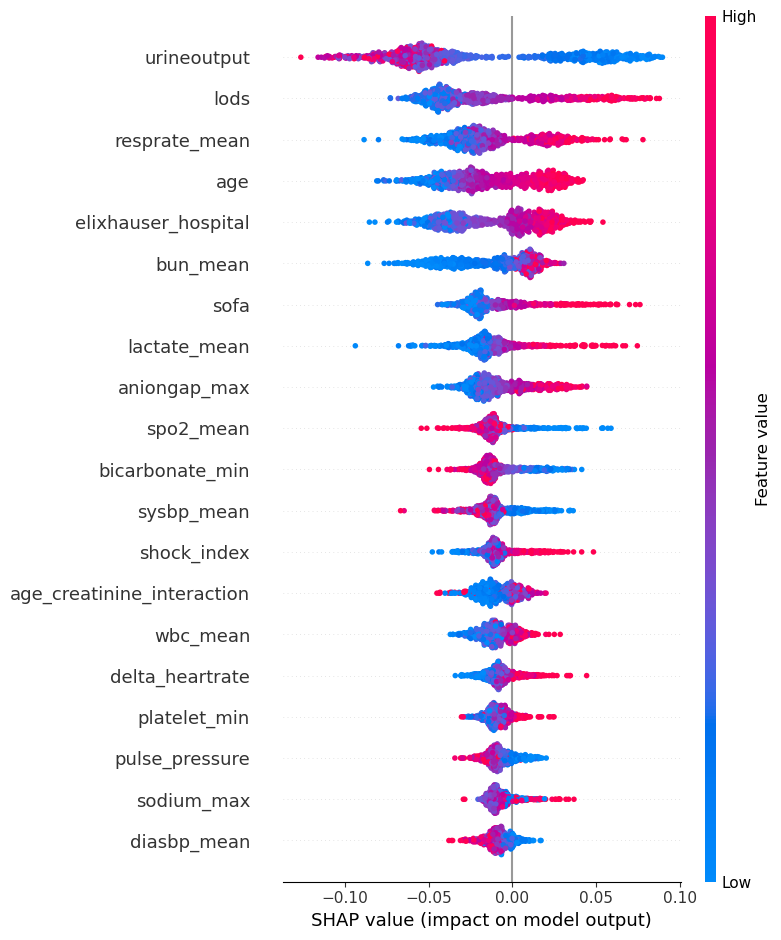

In [193]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create the explainer for each base model separately

# Step 1: Fit each base model individually on training data
rf.fit(X_train, y_train)
#xgb.fit(X_train, y_train)
#lr.fit(X_train, y_train)

# Step 2: Create SHAP explainers
# Explainer for Random Forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Explainer for XGBoost
#explainer_xgb = shap.TreeExplainer(xgb)
#shap_values_xgb = explainer_xgb.shap_values(X_test)

# Explainer for Logistic Regression
# Note that we need to use KernelExplainer for Logistic Regression
#explainer_lr = shap.KernelExplainer(lr.predict_proba, X_train)
#shap_values_lr = explainer_lr.shap_values(X_test, nsamples=100)

# Step 3: Plot SHAP summary plots for each model

# Random Forest SHAP Summary Plot
print("SHAP Summary Plot for Random Forest:")
shap.summary_plot(shap_values_rf[:,:,1], X_test, feature_names=X_test.columns)

## XGBoost SHAP Summary Plot
#print("SHAP Summary Plot for XGBoost:")
#shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns)

# Logistic Regression SHAP Summary Plot
#print("SHAP Summary Plot for Logistic Regression:")
#shap.summary_plot(shap_values_lr[1], X_test, feature_names=X_test.columns)

# Step 4: Interpretation
# To understand the impact of each feature in the different models, you can look at these summary plots


In [50]:
# Assuming shap_values is a 3D array with shape (n_samples, n_features, n_classes)
# Let's say we are interested in the SHAP values for class 1 (positive class)
shap_values_class_1 = shap_values_rf[:, :, 1]  # Extract SHAP values for class 1

# Step 1: Calculate the mean absolute SHAP value for each feature for the selected class
shap_values_abs_mean = np.abs(shap_values_class_1).mean(axis=0)  # Resulting shape: (n_features,)

# Step 2: Create a DataFrame for feature importance based on SHAP values
shap_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Assuming X_train is a DataFrame with named columns
    'Mean_Abs_SHAP_Value': shap_values_abs_mean
})

# Step 3: Sort features by importance
shap_importance_df = shap_importance_df.sort_values(by='Mean_Abs_SHAP_Value', ascending=False)

# Step 4: Get the top n features
n = 15  # You can change this value to the number of top features you want
top_features = shap_importance_df['Feature'].head(n).tolist()

# Print the top n features
print(f"Top {n} features based on SHAP values: {top_features}")

Top 15 features based on SHAP values: ['urineoutput', 'lods', 'age', 'elixhauser_hospital', 'resprate_mean', 'lactate_mean', 'sofa', 'bun_mean', 'aniongap_max', 'sysbp_mean', 'spo2_mean', 'shock_index', 'renal_dysfunction_flag', 'bicarbonate_min', 'age_creatinine_interaction']


In [51]:
#!pip install numpy==1.24